In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ipywidgets import interact, widgets, interactive

**Modeling Exponential Stock Growth: Estimated Growth Rate Over Time**

Presented by: Yany Martinez and Jules Perna



The goal of this project is to model the growth of major tech companies (Tesla, Apple, Nvidia, Amazon, Microsoft, EA) stock prices using exponential curve fitting with the `curve_fit` function in SciPy.

**What does curve fitting do?**

Curve fitting is the process of finding the best parameters that make a function match a set of data points.

The function we are using is the continuous compounding formula (Exponential Growth), the formula is as follows:

$$
A(t) = A_0 \cdot e^{rt}
$$

Where, 

A = starting value (initial stock price)

r = growth rate

t = time (in days)

Within the SciPy library, there is a convenient function called `curve_fit` that can take any mathematical function and fit it to a dataset. This is similar to the polynomial fitting we did in class, but the difference is that we're not limited to polynomial functions. 

**`curve_fit` requires three inputs:**

f = The model function you want to fit

x = Independent variable (in our case a 1D array from 0-250 which represents the amount of days we have data for)

y = Dependent variable (Stock prices)

**`curve_fit` has two outputs:**

popt = A NumPy array containing the best fit values for your models data

[A, r]

pcov = A 2D NumPy array that gives estimated uncertainty (we won't be covering this)

In [2]:
df = pd.read_csv('stocks2.csv', dtype=float, usecols=['Tesla', 'Apple', 'Nvidia', 'Amazon', 'Microsoft', 'Electronic Arts'])

In [ ]:
t = 250
def interest(t, A, r):
    return A*np.exp(r*t)

def stocks(stockType):
    fig, ax = plt.subplots(figsize = (10, 5))
    

    
    x = np.arange(0, 250, 1)
    popt, pcov = curve_fit(interest, x, df[stockType], p0=(700, 0.001), bounds=([0, 0], [np.inf, np.inf]))
    daysFit = np.linspace(0, t - 1, 300)
    pricesFit = interest(daysFit, *popt)

    initial = popt[0]
    rate = popt[1]
    
    ax.plot(x, df[stockType], color = 'darkolivegreen')
    
    ax.plot(daysFit, pricesFit, color = 'purple')

    ax.set_xlabel('Time (From March 2024 - March 2025)', fontname = 'Times New Roman', fontsize = 12)
    ax.set_ylabel('Stock Value', fontname = 'Times New Roman', fontsize = 12)
    ax.grid()
    ax.set_title(f'The approximated growth rate over time is: {round(100*(rate), 2)}%', fontname = 'Times New Roman', fontsize = 12)
    
select = widgets.Select(options = ['Tesla', 'Apple', 'Nvidia', 'Amazon', 'Microsoft', 'Electronic Arts'])
interactivePlot = interactive(stocks, stockType = select)
display(interactivePlot)

interactive(children=(Select(description='stockType', options=('Tesla', 'Apple', 'Nvidia', 'Amazon', 'Microsof…

## Stock Performance Analysis
#### Calculate the 75th percentile of the 7 day log returns

Log returns are commonly used in finance because they are more accurate for compounding and are additive over time. In this part of the analysis We focused on analyzing the performance of each stock over short-term periods using logarithmic returns.

$$
\text{Log Return}_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

This formula calculates the continuously compounded return from one day to the next.

**First:** We use the daily log return, which measures the percent change in stock price from one day to the next using natural logarithms

**Second:** We calculated 7-day rolling log returns, which means we looked at the total return over every 7-day period. This helps capture weekly performance trends.

$$
\text{7-Day Log Return}_t = \sum_{i=0}^{6} \ln\left(\frac{P_{t-i}}{P_{t-i-1}}\right)
$$

- This adds up 7 consecutive daily log returns, giving the total log return for the week ending on day \( t \).
- \( i \): Index for each day in the 7-day window
- The summation runs from \( t-6 \) to \( t \)

This approach is exactly what `rolling(window=7).sum()` does in our code. It creates a rolling window object that slides a 7 row window across the data, on row at the time. At each step, it captures the current value and the previous values (total of 7). Then it apply th sum() operation to that window.

#### **Simplified Formula**
$$
\text{7-Day Log Return}_t = \ln\left(\frac{P_t}{P_{t-7}}\right)
$$


- This simplified formula gives the same result as summing 7 daily log returns.
- It uses only the price at the start and end of the 7-day period.

This version tells you the total percentage return (in log terms) between day \( t-7 \) and day \( t \).

**Finally:** We calculated the 75th percentile of these 7-day log returns for each stock. This tells us what a “strong performance week” looks like — the return that a stock exceeded only 25% of the time.

In [25]:
# Function to calculate stocks performance acrross different weeks

def stocksPerformance(window_size):

    # Calculate the daily log return
    logReturn = np.log(df / df.shift(1))

    # Calculate 7-day rolling log return sums
    logReturn7d = logReturn.rolling(window_size).sum()

    # Calculate the 75th percentile for each stock
    percentile_75 = logReturn7d.quantile(0.75)

    # Plotting the 75th Percentile
    plt.figure(figsize=(12, 7))
    plt.bar(percentile_75.index, percentile_75.values, color='orange')
    plt.title('7 Day Rolling Log Returns by Stocks')
    plt.ylabel('Log Return')
    plt.xlabel('Sotck')
    plt.grid()


#Create widget
DaysOption = widgets.Dropdown(
    options=[7, 14, 21, 30, 60],
    value=7,
    description='Window (days):'
)

#DaysOption = widgets.IntSlider(value=7, min=3, max=30, step=1, description='Window (days):')

# Combine into interactive display
interactivePlot = interactive(stocksPerformance, window_size=DaysOption)
display(interactivePlot)


interactive(children=(Dropdown(description='Window (days):', options=(7, 14, 21, 30, 60), value=7), Output()),…

The first row of daily log returns is NaN because there is no previous day to compare against.
The first 6 rows of 7-day log returns are also NaN because we need a full 7-day window before a valid result can be calculated.

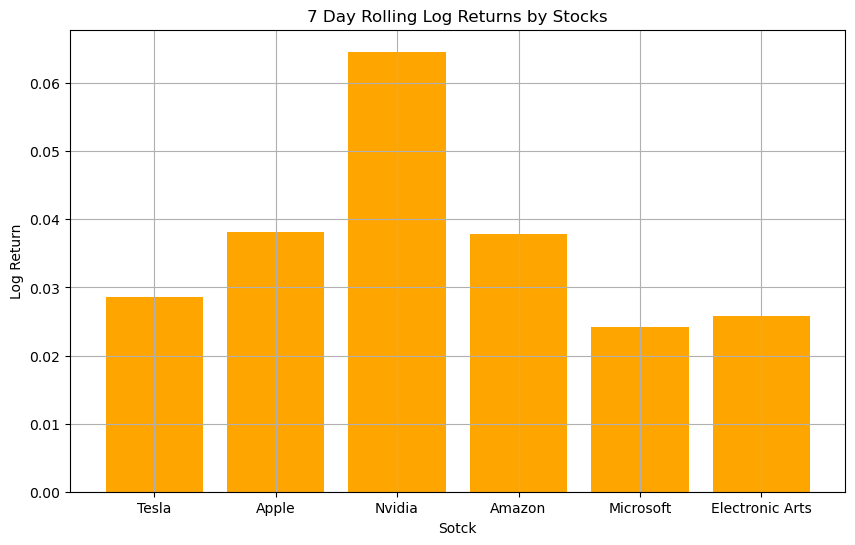

**Observation:** Nvidia had the highest 75th percentile among the stocks, meaning that during its better weeks, it tended to outperform the others. This suggests Nvidia had more aggressive growth in high-return weeks compared to other companies in the dataset.